# Re-fit of Nature Paper with Bayesian Recalibration

In this notebook, we *re-calibrate* the NP data with a Bayesian scheme, and identify the differences in the final constraints.

We use a likelihood in which the variance of $Q_p$ is _measured_ rather than modeled.
In this case, it is measured by taking the variance over integrations in the calibration spectra, after very simple RFI flagging.


All outputs/configs etc are in `nature-paper`.

### Imports

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from getdist import plots, MCSamples, loadMCSamples
from yabf import samplers
from lmfit import Minimizer, Parameters
from yabf import load_likelihood_from_yaml
from yabf.chi2 import MultiComponentChi2

from edges_cal.cal_coefficients import CalibrationObservation, LoadSpectrum
from edges_estimate import LinLog, AbsorptionProfile
from scipy import stats
from edges_cal import modelling as mdl

from scipy import stats
from pathlib import Path
from edges_analysis.analysis import s11 as s11m
from edges_cal import receiver_calibration_func as rcf
import emcee

from scipy.optimize import minimize

## Calibration Posterior

The actual likelihood is created by the script `nature-paper/calibration/create_config.py`, which takes some inputs for the number of terms and frequency range, and produces a configuration YAML file. We read the YAML in here as the full likelihood.

All inputs and outputs in this section are defined in the following path:

In [53]:
calpath = Path('nature-paper/calibration')
estpath = Path('nature-paper/parameter-estimation')

### Fiducial Settings

Here we set some fiducial settings that will be used for the calibration.

In [54]:
cterms=7
wterms=7
fmin = 50.
fmax = 100.

calobs_path = Path('/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz')

### Create Calibration Likelihood

As mentioned above, we use a script to create the likelihood config itself:

In [146]:
!python {calpath/'create_config.py'} {calobs_path} -l {fmin} -h {fmax} -c {cterms} -w {wterms}

Wrote config to /data4/smurray/Projects/radio/EOR/Edges/bayesian-calibration/nature-paper/calibration/Receiver01_25C_2015_09_02_040_to_200MHz_l50.0MHz_h100.0MHz_c9_w9bounds/config.yml


In [247]:
cal_lk = load_likelihood_from_yaml(calpath / f"{calobs_path.name}_l{fmin}MHz_h{fmax}MHz_c{cterms}_w{wterms}bounds/config.yml")

### Inspect Data

In [248]:
calobs = cal_lk['calibrator'].calobs

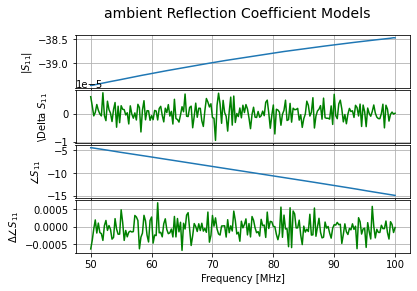

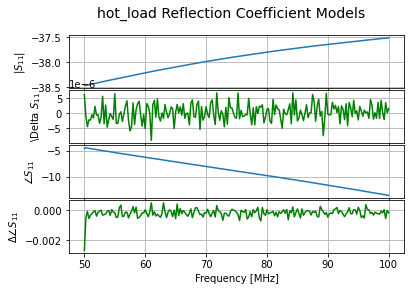

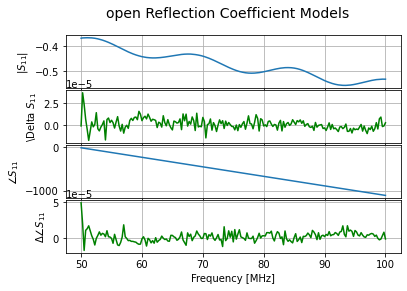

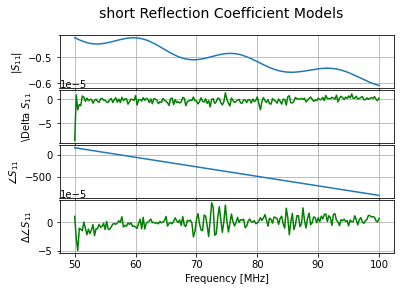

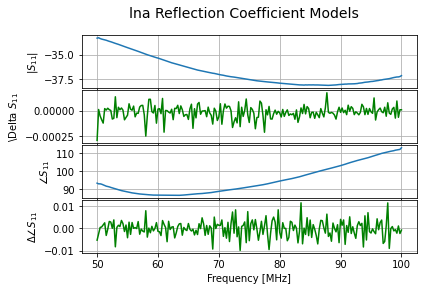

In [149]:
calobs.plot_s11_models();

It seems that the S11's all do OK. Let's have a look at the calibrated spectra:

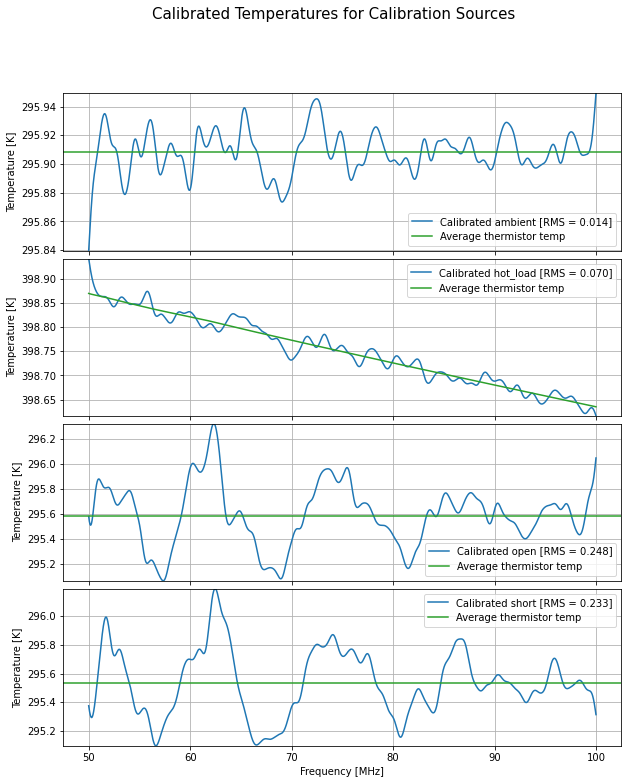

In [150]:
calobs.plot_calibrated_temps();

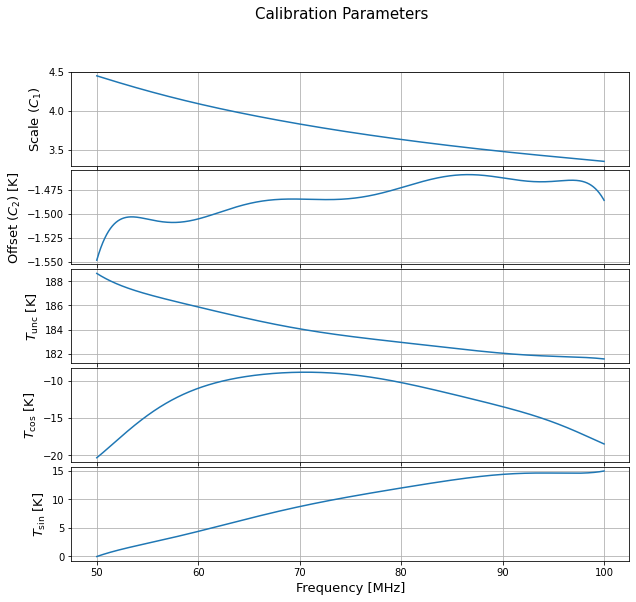

In [151]:
calobs.plot_coefficients();

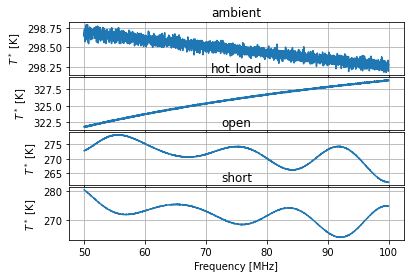

In [152]:
calobs.plot_raw_spectra();

### Downhill-Gradient Fit (for exploration)

#### Perform the Fit

We use the `lmfit` package to perform the downhill-gradient fit here, as it seems to be more flexible than `scipy.optimize.minimize`. It also supports the LM method, which is a bit more robust. The idea is to get a ML fit, and also generate a covariance around that fit.

In [250]:
params = Parameters()
for name, param in cal_lk.child_active_param_dct.items():
    params.add(name, value=param.fiducial, min=param.min, max=param.max)

In [55]:
def calibration_objective(params, lk):
    model = lk.reduce_model(params=params)
    mask = model['data_mask']
    model = model['Qp']
    out = []
    for name, mod in model.items():
        out.append((mod - lk.data[name][mask])/(np.sqrt(2) * lk.sigma[name][mask]))
        
    out = np.concatenate(out)
        
    return out

In [253]:
Minimizer?

In [254]:
cal_lstsq_res = Minimizer(calibration_objective, params, nan_policy='omit', fcn_kws={'lk': cal_lk} ).minimize(method='lstsq')

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/lmfit/minimizer.py:779: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/lmfit/minimizer.py:786: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


In [156]:
cal_lstsq_res.success

True

#### Make Plots

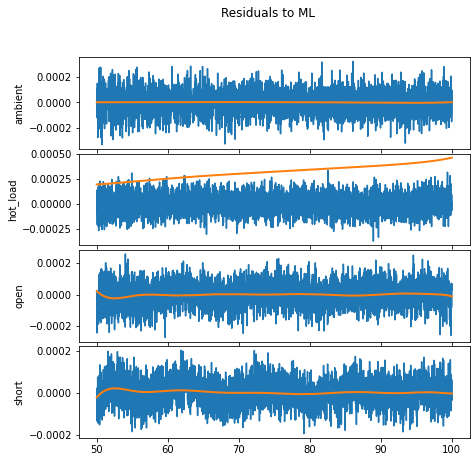

In [157]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(7,7), gridspec_kw={"hspace":0.05})

fid_model = cal_lk.reduce_model()
data_mask = fid_model['data_mask']
fid_model = fid_model['Qp']

ml_params = [p.value for p in cal_lstsq_res.params.values()]
ml_model = cal_lk.reduce_model(params=ml_params)['Qp']

fig.suptitle("Residuals to ML")
for i, (name, fid) in enumerate(fid_model.items()):
    ax[i].plot(cal_lk['calibrator'].freq, cal_lk.data[name][data_mask] - ml_model[name])
    ax[i].plot(cal_lk['calibrator'].freq, fid - ml_model[name], lw=2)
    ax[i].set_ylabel(name)

Interestingly, it seems that iterative solution was better for open/short, but the maximum-likelihood does much better for the hot-load.

We can overplot the calibration curves:

In [158]:
c1, c2, tunc, tcos, tsin = cal_lk['calibrator'].get_calibration_curves(
    {k:v for k,v in zip(cal_lk.child_active_param_dct.keys(), ml_params)}
)

c1_fid, c2_fid, tunc_fid, tcos_fid, tsin_fid = cal_lk['calibrator'].get_calibration_curves(
    {apar.name:apar.fiducial for apar in cal_lk.child_active_params}
)


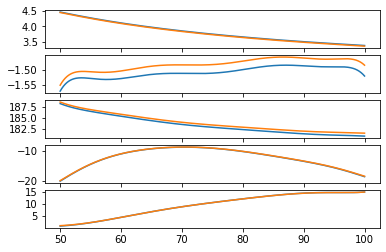

In [159]:
fig, ax = plt.subplots(5, 1, sharex=True)
for i, (ml, fid) in enumerate([(c1, c1_fid), (c2, c2_fid), (tunc, tunc_fid), (tcos, tcos_fid), (tsin, tsin_fid)]):
    ax[i].plot(cal_lk['calibrator'].freq, ml)
    ax[i].plot(cal_lk['calibrator'].freq, fid)

This all seems pretty reasonable -- there is a bit of a shift in the offset, which probably helps with the hot load, but other than that, things are pretty stable.

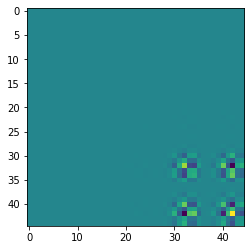

In [160]:
plt.imshow(cal_lstsq_res.covar)

In [161]:
np.savez(calpath / 'calibration-covariance-downhill.npz', cov=cal_lstsq_res.covar, mean=ml_params)

Problematically, this covariance is not positive-definite. We'll have to use a more sophisticated means of getting the posterior.

### With `emcee`

In [162]:
mc_sampler = samplers.emcee(
    cal_lk,
    output_dir=calpath/'emcee',
    output_prefix=cal_lk.name,
    sampler_kwargs={
        'nwalkers': 24 * 6,
        'threads': 24
    }
)

In [163]:
refs = np.random.multivariate_normal(np.array(ml_params), cal_lstsq_res.covar, size=(mc_sampler.nwalkers,))

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [164]:
samples = mc_sampler.sample(
    nsteps=1000,
    restart=True,
    refs=refs
)

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


Removed no burn in


In [ ]:
emc_sampler = emcee.S

In [181]:
emc_sampler = mc_sampler._sampler

#### Plot Raw Chains

(0.0, 1000000.0)

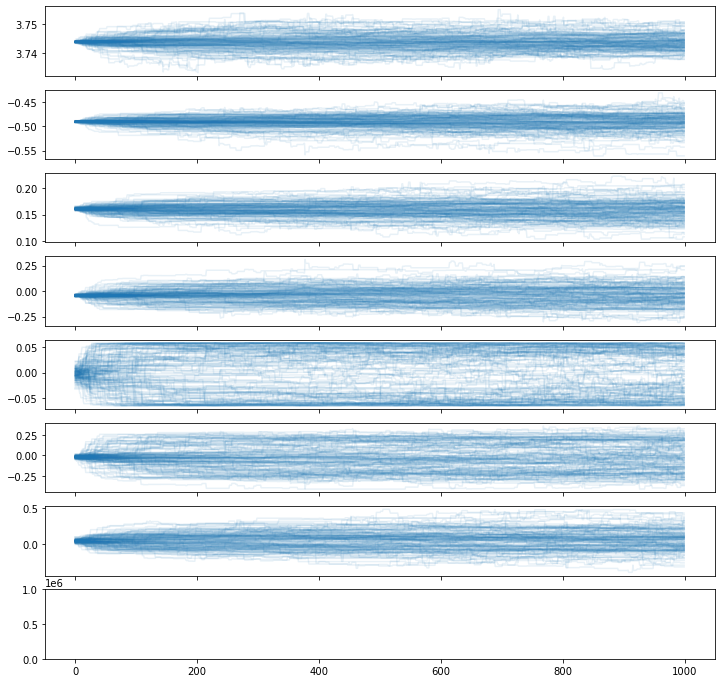

In [182]:
fix, ax = plt.subplots(8, 1, sharex=True, figsize=(12, 12))

for i in range(7):
    for walker in emc_sampler.chain[:,:,i]:
        ax[i].plot(walker, alpha=0.1, color='C0')
        
#for i, walker in enumerate(emc_sampler.lnprobability[mask]):
#    ax[7].scatter(np.arange(len(walker)), walker, alpha=0.1, c=emc_sampler.chain[i,:,0])
    
ax[7].set_ylim(0,1e6)

In [183]:
chain = emc_sampler.get_chain(flat=True, discard=500)

In [184]:
chain.shape

(72000, 45)

In [185]:
emc_sampler.lnprobability.max()

181553.80122721798

#### Plot Calibration Curves

In [188]:
def get_polys(samples, indices=None):
    names = list(cal_lk.child_active_param_dct.keys())
    
    if indices is None:
        indices = list(range(len(samples)))
    if isinstance(indices, int):
        indices = list(range(indices))
        
    c1 = np.zeros((len(indices), len(cal_lk['calibrator'].freq)))
    c2 = np.zeros((len(indices), len(cal_lk['calibrator'].freq)))
    tunc = np.zeros((len(indices), len(cal_lk['calibrator'].freq)))
    tcos = np.zeros((len(indices), len(cal_lk['calibrator'].freq)))
    tsin = np.zeros((len(indices), len(cal_lk['calibrator'].freq)))
    
    for j, ix in enumerate(indices):
        params = {name: v for name, v in zip(names,samples[ix])}
        c1[j], c2[j], tunc[j], tcos[j], tsin[j] = cal_lk['calibrator'].get_calibration_curves(params)
        
    return c1, c2, tunc, tcos, tsin

In [189]:
c1, c2, tunc, tcos, tsin = get_polys(chain, indices=3000)

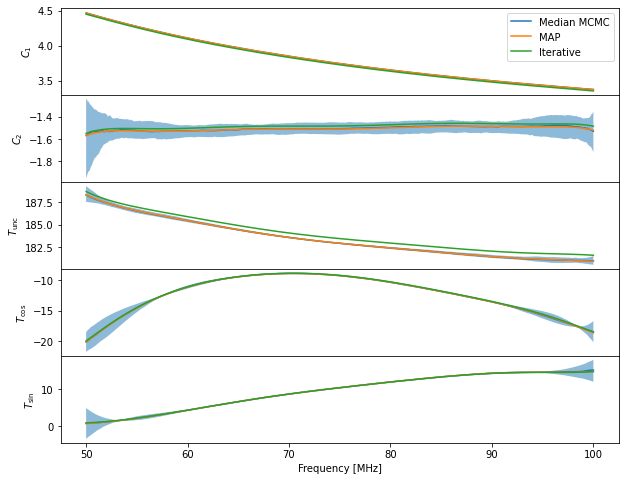

In [190]:
fig, ax = plt.subplots(5,1, sharex=True, gridspec_kw={"hspace": 0}, figsize=(10, 8))
freq = cal_lk['calibrator'].freq
calibrator = cal_lk['calibrator']
names = list(cal_lk.child_active_param_dct.keys())

for i, (name, thing, ml_thing, fid) in enumerate(zip(
    (r'$C_1$', r'$C_2$', r'$T_{\rm unc}$', r'$T_{\rm cos}$', r'$T_{\rm sin}$'), 
    (c1, c2, tunc, tcos, tsin),
    calibrator.get_calibration_curves({name: val for name, val in zip(names, ml_params)}),
    calibrator.get_calibration_curves(
        {apar.name:apar.fiducial for apar in cal_lk.child_active_params}
    ),
)):
    perc = np.percentile(thing, [16, 50, 84], axis=0)
    ax[i].fill_between(freq, perc[0], perc[2], alpha=0.5)
    ax[i].plot(freq, perc[1], label='Median MCMC')
    ax[i].plot(freq, ml_thing, label='MAP')
    ax[i].plot(freq, fid, label='Iterative')
    
    
    ax[i].set_ylabel(name)
    
ax[-1].set_xlabel("Frequency [MHz]")
ax[0].legend()

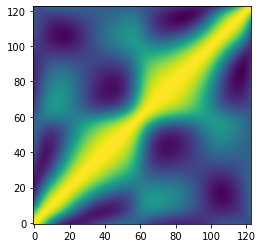

In [191]:
plt.imshow(corr.T, origin='lower')

### With polychord

In [82]:
from getdist import loadMCSamples

In [83]:
samples = loadMCSamples(str(calpath / 'PolyChordChains/config'))

In [88]:
(np.array(ml_params) - samples.getMeans())/np.sqrt(samples.getVars())

array([-0.02299558, -0.00901786,  0.024674  ,  0.03946378, -0.04316109,
       -0.03873829,  0.04783992, -0.02987404,  0.02295578,  0.00422174,
        0.00877201, -0.00997119,  0.00083755, -0.00600686,  0.02003309,
       -0.02142971,  0.02130223, -0.00090393, -0.02909863, -0.00289921,
        0.03726581,  0.00814505,  0.00448515, -0.01007512,  0.01359665,
        0.00896912, -0.02487415, -0.00569184,  0.02697151, -0.02291739,
       -0.01965919,  0.02708877,  0.00988948, -0.0299705 , -0.10020877])

<Figure size 432x324 with 0 Axes>

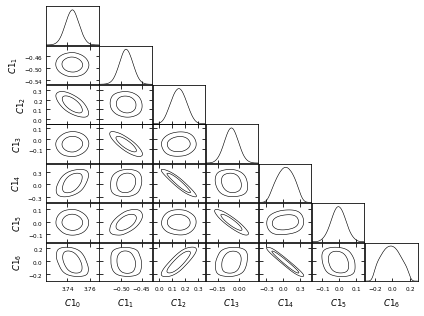

In [89]:
g = plots.get_single_plotter()
g.triangle_plot(samples, ['C1_0', 'C1_1', 'C1_2', 'C1_3', 'C1_4', 'C1_5', 'C1_6'])

In [100]:
def get_polys(samples, indices=None):
    names = list(cal_lk.child_active_param_dct.keys())
    
    if indices is None:
        indices = list(range(len(samples)))
    if isinstance(indices, int):
        indices = list(range(indices))
        
    c1 = np.zeros((len(indices), len(cal_lk['calibrator'].freq)))
    c2 = np.zeros((len(indices), len(cal_lk['calibrator'].freq)))
    tunc = np.zeros((len(indices), len(cal_lk['calibrator'].freq)))
    tcos = np.zeros((len(indices), len(cal_lk['calibrator'].freq)))
    tsin = np.zeros((len(indices), len(cal_lk['calibrator'].freq)))
    
    for ix in indices:
        params = {name: v for name, v in zip(names,samples[ix])}
        c1[ix], c2[ix], tunc[ix], tcos[ix], tsin[ix] = cal_lk['calibrator'].get_calibration_curves(params)
        
    return c1, c2, tunc, tcos, tsin

In [171]:
c1, c2, tunc, tcos, tsin = get_polys(samples.samples, indices=5000)

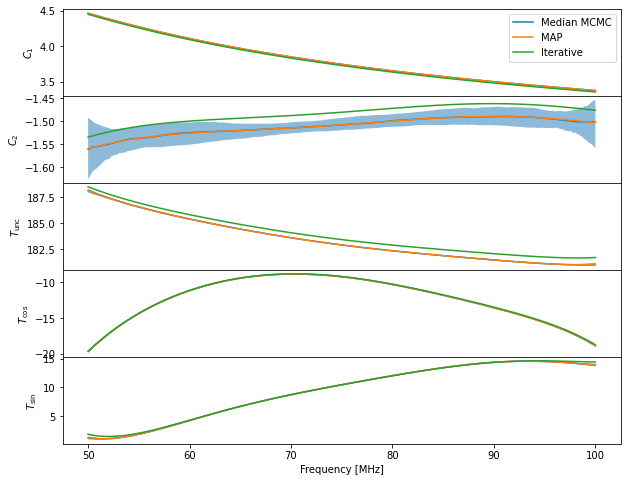

In [172]:
fig, ax = plt.subplots(5,1, sharex=True, gridspec_kw={"hspace": 0}, figsize=(10, 8))
freq = cal_lk['calibrator'].freq
calibrator = cal_lk['calibrator']
names = list(cal_lk.child_active_param_dct.keys())

for i, (name, thing, ml_thing, fid) in enumerate(zip(
    (r'$C_1$', r'$C_2$', r'$T_{\rm unc}$', r'$T_{\rm cos}$', r'$T_{\rm sin}$'), 
    (c1, c2, tunc, tcos, tsin),
    calibrator.get_calibration_curves({name: val for name, val in zip(names, ml_params)}),
    calibrator.get_calibration_curves(
        {apar.name:apar.fiducial for apar in cal_lk.child_active_params}
    )
)):
    perc = np.percentile(thing, [16, 50, 84], axis=0)
    ax[i].fill_between(freq, perc[0], perc[2], alpha=0.5)
    ax[i].plot(freq, perc[1], label='Median MCMC')
    ax[i].plot(freq, ml_thing, label='MAP')
    ax[i].plot(freq, fid, label='Iterative')
    
    ax[i].set_ylabel(name)
    
ax[-1].set_xlabel("Frequency [MHz]")
ax[0].legend()

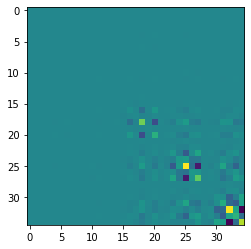

In [175]:
plt.imshow(samples.getCov())

## Data Covariance

In this section, we use the PolyChord chain from above to do our sampling in order to re-calibrate the nature paper data.

First we load the data:

In [56]:
nature_paper_data = np.genfromtxt(calpath/'nature-paper-data.csv', skip_header=1, delimiter=',')

nat_freq = nature_paper_data[:, 0]
nat_temp = nature_paper_data[:, 2]

nat_freq = nat_freq[nat_temp>0]
nat_temp = nat_temp[nat_temp>0]
nat_freq_renorm = cal_lk['calibrator'].calobs.freq.normalize(nat_freq)

downhill_covar = np.load(calpath/'calibration-covariance-downhill.npz')['cov']
dowhnill_means = np.load(calpath/'calibration-covariance-downhill.npz')['mean']

polychord_samples = loadMCSamples(str(calpath / 'PolyChordChains/config'))
#emcee_samples = samples

NameError: name 'cal_lk' is not defined

In [ ]:
def get_cal_curves(params, like):
    def _get(start):
        return np.poly1d([val for key, val in zip(like.child_active_param_dct.keys(), params) if key.startswith(start)][::-1])
    
    return _get('C1'), _get('C2'), _get('Tunc'), _get('Tcos'), _get('Tsin')

def get_fid(params, like):
    return {name: val for name, val in zip(['c1', 'c2', 'tunc', 'tcos', 'tsin'], get_cal_curves(params, like))}

def get_K(freq, like):
    lna = like['calibrator'].calobs.lna.s11_model(freq)
    
    s11_files = sorted(Path('/data5/edges/data/S11_antenna/low_band/20160830_a/s11').glob('*.s1p'))

    switch_state_dir = '/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz/S11/SwitchingState01'
    switch_state_run_num = 1
    n_terms = 13

    model, raw_s11, raw_freq = s11m.antenna_s11_remove_delay(
        s11_files,
        freq,
        switch_state_dir=switch_state_dir,
        delay_0=0.17,
        n_fit=n_terms,
        switch_state_run_num=switch_state_run_num,
    )

    return rcf.get_K(lna, model(freq))
    

def recalibrate(freq, temp, params, fid, K, like):
    scale, offset, tu, tc, ts = get_cal_curves(params, like)

    a, b = rcf.get_linear_coefficients_from_K(
        K, scale(freq), offset(freq), tu(freq), tc(freq), ts(freq), t_load=300,
    )

    decal = (temp - b)/a

    a, b = rcf.get_linear_coefficients_from_K(
        K, fid['c1'](freq), fid['c2'](freq), fid['tunc'](freq), fid['tcos'](freq), fid['tsin'](freq), t_load=300,
    )
    
    return decal*a + b

In [248]:
cal_lstsq_res.covar

array([[ 4.42763488e-13, -1.22853529e-10,  5.10130513e-11, ...,
         6.91232343e-05, -1.89755955e-05, -2.61917665e-05],
       [-1.22853528e-10,  5.93105971e-07, -2.18701172e-07, ...,
        -8.65279635e-03,  2.40071065e-03,  3.26813516e-03],
       [ 5.10130407e-11, -2.18701171e-07,  3.30316489e-06, ...,
         6.25567901e-03, -1.77133865e-03, -2.35999769e-03],
       ...,
       [ 6.91232343e-05, -8.65279635e-03,  6.25567908e-03, ...,
         4.25016729e+02, -1.16560802e+02, -1.61086996e+02],
       [-1.89755955e-05,  2.40071065e-03, -1.77133867e-03, ...,
        -1.16560802e+02,  3.29535147e+01,  4.38638002e+01],
       [-2.61917665e-05,  3.26813517e-03, -2.35999771e-03, ...,
        -1.61086996e+02,  4.38638002e+01,  6.11684478e+01]])

In [ ]:
emc_backend = emcee.backends.HDFBackend('nature-paper/calibration/emcee/calibration_config.yml')

In [255]:
means = cal_lstsq_res.x
fid = get_fid(means, cal_lk)
K = get_K(nat_freq, cal_lk)

In [245]:
ntrials = 5000

means = samples.getMeans()
fid = get_fid(means, cal_lk)
K = get_K(nat_freq, cal_lk)

use = 'downhill'
dst = stats.multivariate_normal(mean=cal_lstsq_res.x, cov=cal_lstsq_res.covar, allow_singular=True)

new_temps = np.zeros((ntrials, len(nat_temp)))
pp = []
c1 = np.zeros_like(new_temps)
c2 = np.zeros_like(new_temps)
tunc = np.zeros_like(new_temps)
tcos = np.zeros_like(new_temps)
tsin = np.zeros_like(new_temps)

for i in range(ntrials):
    if use == 'emcee':
        indx = np.random.randint(len(samples.samples))
        params=samples.samples[indx]
    elif use == 'downhill':
        params = dst.rvs()
    
    _c1, _c2, _tunc, _tcos, _tsin = get_cal_curves(params, cal_lk)
    c1[i] = _c1(nat_freq_renorm)
    c2[i] = _c2(nat_freq_renorm)
    tunc[i] = _tunc(nat_freq_renorm)
    tcos[i] = _tcos(nat_freq_renorm)
    tsin[i] = _tsin(nat_freq_renorm)
    
    new_temps[i] = recalibrate(nat_freq_renorm, nat_temp, params, fid, K, cal_lk)
    pp.append(params)

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/scipy/stats/_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [246]:
cov = np.cov(new_temps.T)
corr = np.corrcoef(new_temps.T)


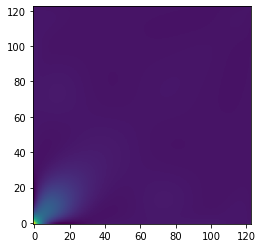

In [196]:
plt.imshow(cov.T, origin='lower')

Text(0, 0.5, 'Frequency [MHz]')

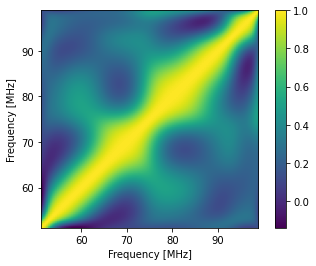

In [197]:
plt.imshow(corr.T, origin='lower', extent=(nat_freq.min(), nat_freq.max(), nat_freq.min(), nat_freq.max()))
plt.colorbar()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Frequency [MHz]")

Text(0, 0.5, 'Frequency [MHz]')

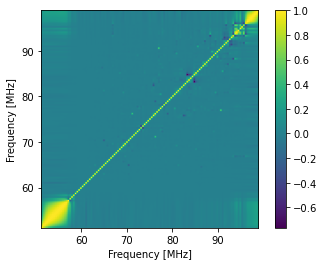

In [247]:
plt.imshow(corr.T, origin='lower', extent=(nat_freq.min(), nat_freq.max(), nat_freq.min(), nat_freq.max()))
plt.colorbar()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Frequency [MHz]")

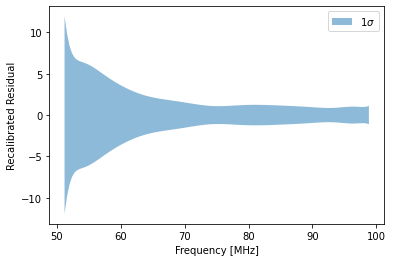

In [244]:
plt.fill_between(nat_freq, -np.sqrt(np.diag(cov)), np.sqrt(np.diag(cov)),alpha=0.5, label=r'$1\sigma$')
plt.xlabel("Frequency [MHz]")
plt.ylabel("Recalibrated Residual")
plt.legend();

In [198]:
np.savez(estpath / 'data_covariance.npz', cov=cov, mean=np.mean(new_temps, axis=0))
np.save(estpath /'data-sigma.npy', np.sqrt(np.diag(cov)))
np.save( estpath /'data-cov.npy', cov)

## Absorption Posterior

In this section, we will use the covariances derived in the previous section to re-fit the nature paper data. We'll first do a simple downhill-gradient fit, then try a full-blown `emcee` or `polychod` fit.

### Define the Likelihoods

In [ ]:
nature_paper_data = np.genfromtxt(calpath/'nature-paper-data.csv', skip_header=1, delimiter=',')

nat_freq = nature_paper_data[:, 0]
nat_wght = nature_paper_data[:, 1]
nat_temp = nature_paper_data[:, 2]


nat_freq = nat_freq[nat_temp>0]
nat_temp = nat_temp[nat_temp>0]
nat_wght = nat_wght[nat_wght>0]

# Only if we want to restrict the frequency range.
# mask = (nat_freq >= 55.) & (nat_freq <= 98)
# nat_temp = nat_temp[mask]
# nat_wght = nat_wght[mask]
# nat_freq = nat_freq[mask]

In [ ]:
cov = np.load(estpath / 'data_covariance.npz')['cov']
# cov = cov[mask][:, mask]

# We need to add thermal variance
therm_var = 0.013 ** 2
cov += therm_var * np.eye(len(cov))
var_wght = therm_var / (nat_wght/nat_wght.max())
var_cal = np.diag(cov)

In [ ]:
def make_fg(n, fix_beta=False):
    if not fix_beta:
        params = {
            'beta': {'min': -3.5, 'max': -1.5, 'prior': stats.norm(loc=-2.55, scale=0.01)},
        }
    else:
        params = {}
        
    params['p0'] =  {'min': 1500, 'max': 2000}
    for i in range(1,n):
        params[f'p{i}'] = {'min': -10000, 'max': 10000}
        
    return LinLog(
        name='fg',
        freqs=nat_freq,
        poly_order=n,
        params=params,
        use_p1=True
    )

def make_absorption(fix=tuple()):
    params={
        'A': {'max':2, 'min': 0, 'fiducial': 0.5}, 
        'nu0': {'min': 60, 'max': 90, 'fiducial': 78}, 
        'tau': {'min': 1, 'max': 20, 'fiducial': 8}, 
        'w': {'min':1, 'max': 25, 'fiducial': 15}
    }
    
    fid = {}
    for p in fix:
        fid[p] = params.pop(p)['fiducial']
        
    return AbsorptionProfile(
        name='absorption',
        fiducial=fid,
        params=params,
        freqs=nat_freq,
        derived=('spectrum',)
    )

def make_param_lk(sigma, fix=tuple(), n=5, fix_beta=False):
    return MultiComponentChi2(
        components=(
            make_absorption(fix),
            make_fg(n, fix_beta)
        ),
        kind='spectrum',
        data=nat_temp,
        sigma=sigma,
        derived=('residual',)
    )

In [ ]:
cov_lk = make_param_lk(cov)
therm_lk = make_param_lk(therm_var, fix_beta=True)
sig_lk = make_param_lk(np.sqrt(var_cal))
wght_lk = make_param_lk(np.sqrt(var_wght), fix_beta=True)

### Downhill-Gradient Fits

#### First, let's just fit foregrounds

In [ ]:
physlin = mdl.PhysicalLin(default_x=nat_freq, n_terms=5)
physlin_fit = physlin.fit(ydata=nat_temp)

In [ ]:
edgespoly = mdl.EdgesPoly(default_x=nat_freq, n_terms=5)
edgespoly_fit = edgespoly.fit(ydata=nat_temp)

In [ ]:
linlog = mdl.LinLog(default_x=nat_freq, n_terms=5)
linlog_fit = linlog.fit(ydata=nat_temp)

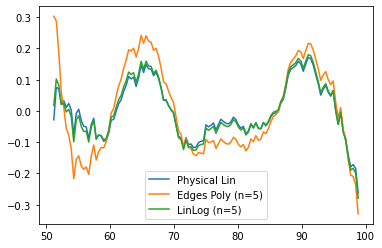

In [206]:
plt.plot(physlin_fit.xdata, physlin_fit.residual, label='Physical Lin')
plt.plot(edgespoly_fit.xdata, edgespoly_fit.residual, label='Edges Poly (n=5)')
plt.plot(linlog_fit.xdata, linlog_fit.residual, label='LinLog (n=5)')
plt.legend()

#### Joint-Constraint

In [57]:
class QuickFit:
    def __init__(self, eor, data, fg, var, fit_beta=False, p = None):
        self.eor = eor
        self.data = data
        self.fg = fg
        self.var = var
        self.p = p
        self.__cache = {}
        if hasattr(var, 'ndim') and var.ndim==2:
            self.norm_obj = stats.multivariate_normal(mean=np.zeros_like(resid), cov=var)
        else:
            self.norm_obj = stats.norm(loc=0, scale=np.sqrt(var))
        self.fit_beta = fit_beta
        
    def get_eor(self, p=None):
        if p is None:
            p = self.p
        if self.fit_beta:
            p = p[:-1]
        return self.eor(params=p)['eor_spectrum']

    def get_fit(self, p=None):
        if str(p) in self.__cache:
            return self.__cache[str(p)]
        
        eor = self.get_eor(p)
        resid = self.data - eor
        
        if self.fit_beta:
            del self.fg.default_basis
            if p is not None:
                self.fg.beta = p[-1]
            else:
                self.fg.beta = self.p[-1]
            
        out = self.fg.fit(ydata=resid, weights=1/self.var)
        self.__cache[str(p)] = out
        return out
    
    def resid(self, p=None):
        return self.get_fit(p).residual
    
    def fg_params(self, p = None):
        return self.get_fit(p).model_parameters
    
    def __call__(self, p=None):
        return -np.sum(self.norm_obj.logpdf(self.resid(p)))

In [225]:
def get_diags(a, n=1):
    out = np.zeros_like(a)
    for i in range(len(a)):
        for j in range(len(a)):
            if j-n < i < j+n:
                out[i, j] = a[i, j]
    return out

def constrain(a, n=1):
    x = np.arange(len(a))
    return np.exp(-np.add.outer(x,-x)**2/n**2) * a

In [238]:
cov_n = constrain(cov, 5)
corr = cov_n / np.outer(np.sqrt(np.diag(cov_n)), np.sqrt(np.diag(cov_n)))

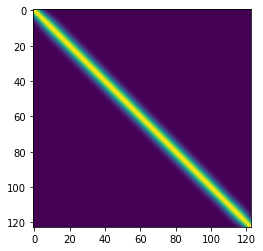

In [239]:
plt.imshow(corr)

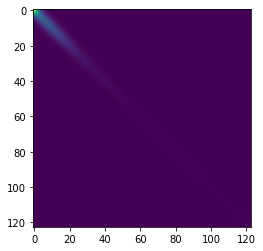

In [237]:
plt.imshow(constrain(cov, 5))

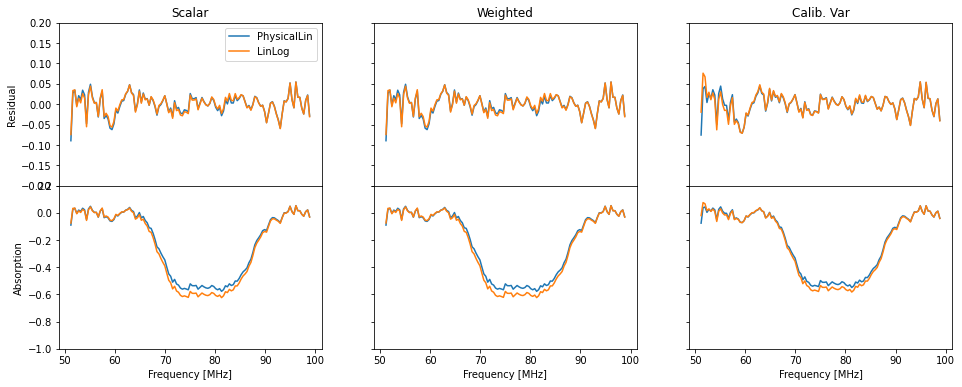

In [77]:
eor =  make_absorption()

res_dict = {}

fig, ax = plt.subplots(2,3, sharex=True, figsize=(16,6), sharey='row', gridspec_kw={'hspace':0})
for j, (name, sigma) in enumerate(zip(
    ['Scalar', 'Weighted', 'Calib. Var'],#, 'Calib. Covar'],
    [therm_var, var_wght, var_cal]#, cov]
)):
    res_dict[name] = {}
    for i, fg in enumerate([physlin, linlog]):
        quick_fit = QuickFit(eor, nat_temp, fg, sigma)
        
        res = minimize(
            quick_fit, 
            x0=[apar.fiducial for apar in eor.child_active_params], 
            bounds=[(apar.min, apar.max) for apar in eor.child_active_params],
        )
        
        if not res.success:
            print(f"{name} with {fg.__class__.__name__} did not succeed.")
            
        resid = quick_fit.resid(res.x)
        absorp = quick_fit.get_eor(res.x)
        
        ax[0, j].plot(nat_freq, resid, label=fg.__class__.__name__, color=f'C{i}')
        ax[1, j].plot(nat_freq, absorp + resid, label=fg.__class__.__name__, color=f'C{i}')
        ax[0,j].set_ylim(-0.2,0.2)
        ax[1, j].set_ylim(-1, 0.2)
        
        res_dict[name][fg.__class__.__name__] = res
    ax[0, j].set_title(name)
    ax[1, j].set_xlabel("Frequency [MHz]")
    
ax[0,0].set_ylabel("Residual")
ax[1,0].set_ylabel("Absorption")
ax[0,0].legend()

This is quite amazing -- the best fits for both physlin and linlog remain the same even with the extra variance! However, we can't say much about the uncertainties here.

In [214]:
res_dict['Calib. Covar']['LinLog'].hess_inv.todense()

array([[  1.17915582,  -0.88482727, -11.01919631,  -1.12505775],
       [ -0.88482727,   1.08938833,   8.1763127 ,   0.75534194],
       [-11.01919631,   8.1763127 , 106.65576357,  10.3380679 ],
       [ -1.12505775,   0.75534194,  10.3380679 ,   1.78805623]])

I'm not sure what this means exactly. However, we can run either polychord or `emcee`.

#### Vary beta

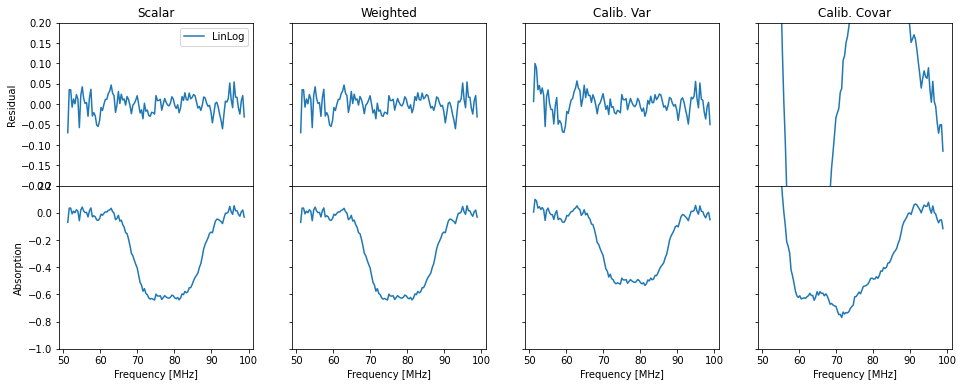

In [24]:
res_dict_beta = {}

fig, ax = plt.subplots(2,4, sharex=True, figsize=(16,6), sharey='row', gridspec_kw={'hspace':0})
for j, (name, sigma) in enumerate(zip(
    ['Scalar', 'Weighted', 'Calib. Var', 'Calib. Covar'],
    [therm_var, var_wght, var_cal, cov]
)):
    res_dict_beta[name] = {}
    for i, fg in enumerate([linlog]):
        quick_fit = QuickFit(eor, nat_temp, fg, sigma, fit_beta=True)
        
        res = minimize(
            quick_fit, 
            x0=[apar.fiducial for apar in eor.child_active_params] + [-2.5], 
            bounds=[(apar.min, apar.max) for apar in eor.child_active_params] + [(-2.6, -2.4)],
        )
        
        if not res.success:
            print(f"{name} with {fg.__class__.__name__} did not succeed.")
            
        resid = quick_fit.resid(res.x)
        # resid_nature = get_resid([0.53, 78.1, 7, 18.7], eor, nat_temp, fg, sigma)
        absorp = quick_fit.get_eor(res.x)
        
        ax[0, j].plot(nat_freq, resid, label=fg.__class__.__name__, color=f'C{i}')
        ax[1, j].plot(nat_freq, absorp + resid, label=fg.__class__.__name__, color=f'C{i}')
        ax[0,j].set_ylim(-0.2,0.2)
        ax[1, j].set_ylim(-1, 0.2)
        
        res_dict_beta[name][fg.__class__.__name__] = res
        #ax.flatten()[j].plot(nat_freq, resid_nature,ls='-', label=fg.__class__.__name__, color=f"C{i}")
    ax[0, j].set_title(name)
    ax[1, j].set_xlabel("Frequency [MHz]")
    
ax[0,0].set_ylabel("Residual")
ax[1,0].set_ylabel("Absorption")
ax[0,0].legend()

In [25]:
res_dict_beta['Calib. Covar']['LinLog']

      fun: -225.05487606778647
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.30179024,  0.11404787,  0.1181462 ,  0.00188152, -0.04853007])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 408
      nit: 35
     njev: 68
   status: 0
  success: True
        x: array([ 0.97152401, 77.88716075,  3.79222961, 18.62597187, -2.57448243])

In [21]:
quick_fit = QuickFit(eor, nat_temp, fg, sigma, fit_beta=True, p = [ 0.95485649, 77.88766051,  3.84933435, 18.63502859, -2.64856181])

In [22]:
quick_fit.resid()

array([ 2.65593744,  2.39783331,  2.0656079 ,  1.71982392,  1.46363721,
        1.20057087,  0.99513209,  0.77733521,  0.52089171,  0.43167051,
        0.30201921,  0.13843473,  0.00555067, -0.09910107, -0.2270391 ,
       -0.26423039, -0.31562383, -0.4436112 , -0.48844915, -0.54122814,
       -0.60078474, -0.63445943, -0.64410339, -0.62907128, -0.64841187,
       -0.64019737, -0.63031845, -0.62757418, -0.6072187 , -0.59062925,
       -0.56169153, -0.56445105, -0.54994981, -0.56740884, -0.52317897,
       -0.46116507, -0.45964967, -0.40391633, -0.38373464, -0.34564985,
       -0.3242966 , -0.2664234 , -0.23698469, -0.21488716, -0.19955726,
       -0.14349939, -0.10473507, -0.06259896, -0.01889116, -0.00688938,
        0.00360269,  0.04297957,  0.05225317,  0.12102183,  0.13124002,
        0.16276903,  0.17698893,  0.20149892,  0.23650093,  0.25857704,
        0.27712762,  0.34287099,  0.34957968,  0.3673287 ,  0.38652447,
        0.37471005,  0.40292572,  0.42942206,  0.43150117,  0.43

In [23]:
quick_fit.resid() - quick_fit.resid([ 0.96287807, 77.88745536,  3.82173286, 18.63011844, -2.5])

array([ 3.91834800e-01,  3.33169728e-01,  2.80826317e-01,  2.34263159e-01,
        1.92979089e-01,  1.56510387e-01,  1.24428172e-01,  9.63359619e-02,
        7.18674160e-02,  5.06842151e-02,  3.24740942e-02,  1.69490052e-02,
        3.84340461e-03, -7.08734370e-03, -1.60684580e-02, -2.33071283e-02,
       -2.89938119e-02, -3.33034428e-02, -3.63965593e-02, -3.84203551e-02,
       -3.95096592e-02, -3.97878477e-02, -3.93676915e-02, -3.83521426e-02,
       -3.68350603e-02, -3.49018814e-02, -3.26302320e-02, -3.00904864e-02,
       -2.73462709e-02, -2.44549156e-02, -2.14678579e-02, -1.84310005e-02,
       -1.53850316e-02, -1.23657173e-02, -9.40417739e-03, -6.52716166e-03,
       -3.75734163e-03, -1.11363437e-03,  1.38843060e-03,  3.73629837e-03,
        5.91993900e-03,  7.93138530e-03,  9.76429625e-03,  1.14135933e-02,
        1.28752166e-02,  1.41460343e-02,  1.52239125e-02,  1.61079197e-02,
        1.67986027e-02,  1.72982520e-02,  1.76110693e-02,  1.77431698e-02,
        1.77023940e-02,  

In [42]:
linlog.beta

-2.4

### emcee

In [184]:
eor_sampler = samplers.emcee(
    wght_lk,
    output_dir=estpath/'emcee',
    output_prefix=wght_lk.name,
    sampler_kwargs={
        'nwalkers': 24 * 6,
        'threads': 24
    }
)

In [185]:
q = QuickFit(eor=make_absorption(), data=nat_temp, fg=linlog, var=var_cal, fit_beta=False, p = res_dict['Weighted']['LinLog'].x)
linlog_params = q.fg_params()

In [189]:
p0 = res_dict['Calib. Var']['LinLog'].x.tolist() + linlog_params.tolist()

In [190]:
refs = np.random.normal(loc=p0, scale=np.abs(0.01*np.array(p0)), size=(eor_sampler.nwalkers,len(p0)))

In [151]:
p1 = p0.copy()
p1[1] -= 0.01

In [152]:
wght_lk(params=p0)[0], wght_lk(params=p1)[0] 

(-3.6241802700437793, -3.650575510903378)

In [191]:
eor_mc_samples = eor_sampler.sample(
    nsteps=3000,
    restart=True,
    refs=refs
)

Removed no burn in


In [192]:
eor_emc_samples = eor_sampler._sampler

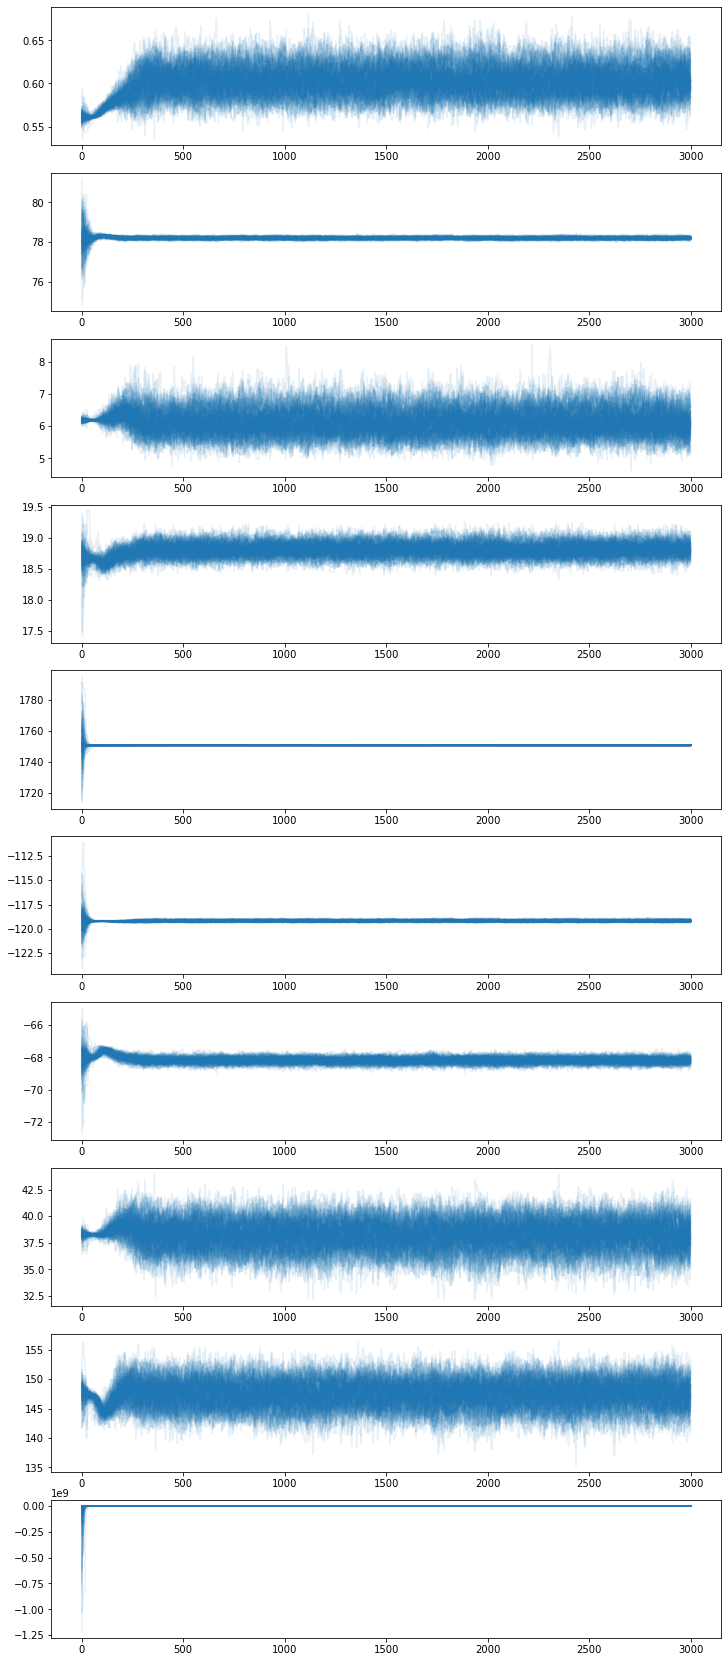

In [193]:
fig, ax = plt.subplots(eor_emc_samples.chain.shape[-1]+1, 1, figsize=(12, 3*(eor_emc_samples.chain.shape[-1]+1)))

for i, param in enumerate(eor_emc_samples.chain.T):
    for walker in param.T:
        ax[i].plot(walker, color='C0', alpha=0.1)
        
for walker in eor_emc_samples.lnprobability:
    ax[-1].plot(walker, color='C0', alpha=0.1)

In [247]:
p1 = p0.copy()
p1[0] = 1.9

In [248]:
cov_lk(params=p0)[0], cov_lk(params=p1)[0]

(-24630.474541276606, -24255.22787470361)

In [252]:
np.where(eor_emc_samples.lnprobability == eor_emc_samples.lnprobability.max())

(array([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14]),
 array([2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772,
        2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780]))

In [253]:
eor_emc_samples.chain[14, 2762]

array([ 8.77074774e-01,  6.26192526e+01,  2.77660011e+00,  1.05504429e+00,
       -2.54958353e+00,  1.75020004e+03, -3.55673397e+01, -4.42318666e+01,
        8.18498172e+01, -8.99612568e+01])

In [257]:
cov_lk(params=eor_emc_samples.chain[14, 2762])[0], cov_lk(params=p0)[0]

(-270.2780096156519, -24630.474541276606)

In [281]:
cov_lk_no_beta = make_param_lk(cov, fix_beta=True)

eor_sampler = samplers.emcee(
    cov_lk_no_beta,
    output_dir=estpath/'emcee',
    output_prefix='no_beta',
    sampler_kwargs={
        'nwalkers': 24 * 6,
        'threads': 24
    }
)

{'p0': {'min': 1500, 'max': 2000}, 'p1': {'min': -10000, 'max': 10000}, 'p2': {'min': -10000, 'max': 10000}, 'p3': {'min': -10000, 'max': 10000}, 'p4': {'min': -10000, 'max': 10000}}


In [282]:
p0_nb = res_dict['Calib. Covar']['LinLog'].x.tolist() + linlog_params.tolist()

In [283]:
refs_nb = np.random.normal(loc=p0_nb, scale=np.abs(0.01*np.array(p0_nb)), size=(eor_sampler.nwalkers,len(p0_nb)))

In [286]:
len(cov_lk_no_beta.child_active_params)

9

In [289]:
len(refs_nb.T)

10

In [288]:
eor_mc_samples_no_beta = eor_sampler.sample(
    nsteps=3000,
    restart=True,
    refs=refs_nb.T
)

ValueError: incompatible input dimensions

In [299]:
no_beta_emc_sampler = eor_sampler._sampler

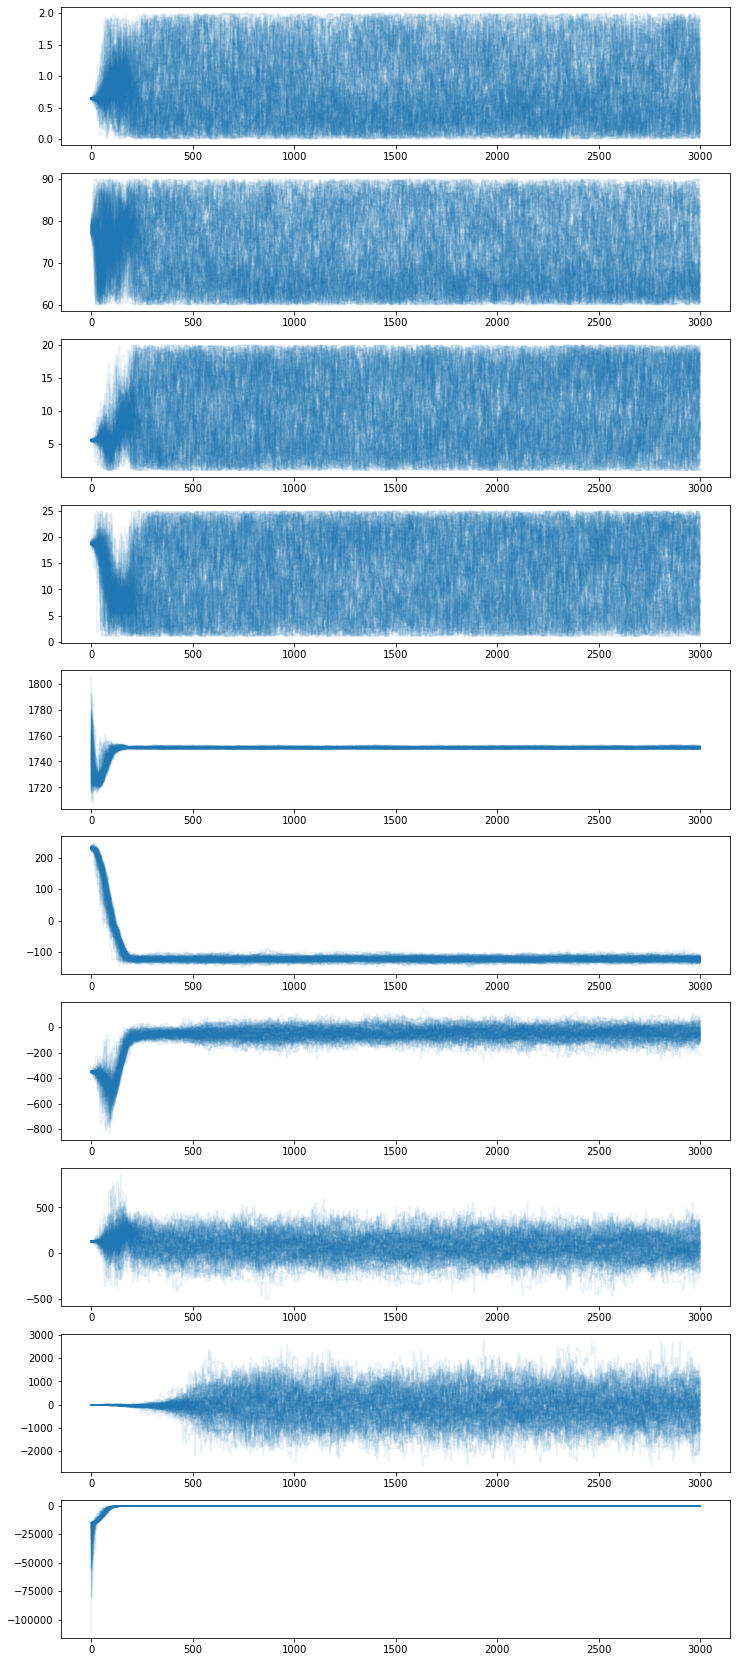

In [300]:
fig, ax = plt.subplots(no_beta_emc_sampler.chain.shape[-1]+1, 1, figsize=(12, 3*(no_beta_emc_sampler.chain.shape[-1]+1)))

for i, param in enumerate(no_beta_emc_sampler.chain.T):
    for walker in param.T:
        ax[i].plot(walker, color='C0', alpha=0.1)
        
for walker in no_beta_emc_sampler.lnprobability:
    ax[-1].plot(walker, color='C0', alpha=0.1)

In [301]:
np.where(no_beta_emc_sampler.lnprobability == no_beta_emc_sampler.lnprobability.max())

(array([49]), array([1047]))

In [302]:
no_beta_emc_sampler.chain[49, 1047]

array([ 3.87624792e-01,  7.80428492e+01,  1.29056077e+01,  2.01082928e+01,
        1.75060164e+03, -1.20939844e+02, -6.17857746e+01,  6.19600842e+01,
        1.16129740e+02])

In [303]:
neg_lk(no_beta_emc_sampler.chain[49, 1047, :4], eor, nat_temp, linlog, cov)

-120.21697086246635

In [304]:
no_beta_emc_sampler.lnprobability[49, 1047]

-273.95654391196535

In [305]:
eor_model = eor(params=no_beta_emc_sampler.chain[49, 1047, :4])['eor_spectrum']

In [311]:
resid = nat_temp - eor_model
fg_params = linlog.fit(ydata=resid, weights=1/cov**2)

In [316]:
print(fg_params.model_parameters)
print(fg_params2.model_parameters)

[1750.59344831 -119.78089681  -61.83807127   62.65614432   41.2464199 ]
[1750.59269611 -119.96184225  -58.80389239   49.54262819   63.88940898]


In [314]:
fg_params2 = linlog.fit(ydata=resid, weights=1/cov)

In [317]:
linlog.beta

-2.5

In [ ]:
def get_eor(p, absorption):
    return 
    
def get_resid(p, absorption, data, fg, sigma):
    eor = get_eor(p, absorption)
    resid = data - eor
    return fg.fit(ydata=resid, weights=1/sigma**2 if hasattr(sigma, '__len__') else None).residual

In [ ]:
def neg_lk(p, absorption, data, fg, sigma):
    resid = get_resid(p, absorption, data, fg, sigma)
    if hasattr(sigma, 'ndim') and sigma.ndim==2:
        norm_obj = stats.multivariate_normal(mean=np.zeros_like(resid), cov=sigma)
    else:
        norm_obj = stats.norm(loc=0, scale=sigma)
        
    return -np.sum(norm_obj.logpdf(resid))

### Testing Modelling

In [52]:
x = np.linspace(0, 1, 20)
y = 3 + x + x**2 + 2*x**3

cov = np.exp(-2*np.add.outer(x, -x)**2)

In [53]:
cov.max()

1.0

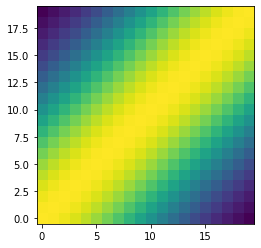

In [54]:
plt.imshow(cov.T, origin='lower')

In [55]:
e = np.random.multivariate_normal(np.zeros(20), cov=cov)

In [56]:
data= y + e

In [57]:
from statsmodels.api import GLS

In [60]:
np.linalg.cholesky(cov)

LinAlgError: Matrix is not positive definite

In [48]:
m = GLS(y, np.array([np.ones(len(x)), x, x**2, x**3]).T, sigma=cov.T)

LinAlgError: Matrix is not positive definite

In [49]:
cov

array([[1.        , 0.99172419, 0.96730541, 0.92793625, 0.87549662,
        0.81240505, 0.74143411, 0.6655096 , 0.58751356, 0.51010933,
        0.43560259, 0.36584696, 0.30219708, 0.24550643, 0.19616309,
        0.15415355, 0.11914383, 0.0905673 , 0.06771004, 0.04978707],
       [0.99172419, 1.        , 0.99172419, 0.96730541, 0.92793625,
        0.87549662, 0.81240505, 0.74143411, 0.6655096 , 0.58751356,
        0.51010933, 0.43560259, 0.36584696, 0.30219708, 0.24550643,
        0.19616309, 0.15415355, 0.11914383, 0.0905673 , 0.06771004],
       [0.96730541, 0.99172419, 1.        , 0.99172419, 0.96730541,
        0.92793625, 0.87549662, 0.81240505, 0.74143411, 0.6655096 ,
        0.58751356, 0.51010933, 0.43560259, 0.36584696, 0.30219708,
        0.24550643, 0.19616309, 0.15415355, 0.11914383, 0.0905673 ],
       [0.92793625, 0.96730541, 0.99172419, 1.        , 0.99172419,
        0.96730541, 0.92793625, 0.87549662, 0.81240505, 0.74143411,
        0.6655096 , 0.58751356, 0.51010933, 0

## Try EVERYTHING at ONCE.

In [24]:
import attr
from yabf import Likelihood, Parameter

In [48]:
@attr.s(frozen=True)
class CalibrationPlus(Likelihood):
    """Data should be passed as a dict of {source: qp}.
    """
    base_parameters = [
        Parameter("sigma_scale", 1, min=0, latex=r"f_\sigma")
    ]

    sigma = attr.ib(None, kw_only=True)
    spec_sigma = attr.ib(None, kw_only=True)
    use_model_sigma = attr.ib(default=False, converter=bool, kw_only=True)
    freq = attr.ib(None, kw_only=True)
    K = attr.ib(None, kw_only=True)
    
    def _reduce(self, ctx, **params):
        out = {}
        for k in ctx:
            if k.endswith("calibration_q"):
                out['Qp'] = ctx[k]
                break

        for k in ctx:
            if k.endswith("calibration_qsigma"):
                out['curlyQ'] = ctx[k]
                break

        out['spectrum'] = np.sum([val for key, val in ctx.items() if key.endswith('spectrum')], axis=0)
        out['cal_curves'] = ctx['cal_curves']
        out['data_mask'] = ctx['data_mask']

        out['recal_spec'] = self.recalibrate(
            self.freq, self.data['uncal_spectrum'], self.K, 
            ctx['cal_curves']['c1'], ctx['cal_curves']['c2'], ctx['cal_curves']['tu'], ctx['cal_curves']['tc'], 
            ctx['cal_curves']['ts']
        )
        return out


    def recalibrate(self, freq, uncal, K, scale, offset, tu, tc, ts):
        a, b = rcf.get_linear_coefficients_from_K(
            K, scale(freq), offset(freq), tu(freq), tc(freq), ts(freq), t_load=300,
        )

        return uncal*a + b

    def get_sigma(self, model, source=None, **params):
        if self.sigma is not None:
            if isinstance(self.sigma, dict):
                return self.sigma[source][model['data_mask']]
            else:
                return self.sigma
        elif not self.use_model_sigma:
            return params['sigma_scale']
        else:
            return params['sigma_scale'] * model['Qp'][source]**2 * (1 + model['curlyQ'][source])

    def _mock(self, model, **params):
        sigma = self.get_sigma(model, **params)
        return model + np.random.normal(loc=0, scale=sigma, size=len(model))

    def lnl(self, model, **params):
        lnl = 0
        for source, data in self.data['Q'].items():
            sigma = self.get_sigma(model, source=source, **params)
            lnl += -np.nansum(
                np.log(sigma) + (model['Qp'][source] - data[model['data_mask']])**2 / (2 * sigma**2)
            )
            # nm = stats.norm(loc=model['Qp'][source], scale=sigma)
            # lnl += np.sum(nm.logpdf(data))
            if np.isnan(lnl):
                lnl = -np.inf
                break
        #spec_data = self.recalibrate(self.freq, self.data['uncal_spectrum'], self.K, params['calibrator'])

        
        # Ensure we don't use flagged channels
        mask = ~np.isnan(model['recal_spec'])
        d = model['recal_spec'][mask]
        m = model['spectrum'][mask]

        sigma = self.spec_sigma

        if isinstance(sigma, (float, int)):
            sigma = sigma * np.ones_like(d)

        s = sigma[mask][:, mask] if sigma.ndim == 2 else sigma[mask]

        if s.ndim <=2 or is_diagonal(s):
            if s.ndim == 2:
                s = np.diag(s)
            nm = stats.norm(loc=m, scale=s)
        else:
            nm = stats.multivariate_normal(mean=m, cov=s, allow_singular=True)

        lnl += np.sum(nm.logpdf(d))
        if np.isnan(lnl):
            lnl = -np.inf
        return lnl

In [37]:
K = get_K(nat_freq, cal_lk)

In [38]:
calobs = cal_lk['calibrator'].calobs

In [39]:
a, b = rcf.get_linear_coefficients_from_K(
    K, calobs.C1(nat_freq), calobs.C2(nat_freq), calobs.Tunc(nat_freq), calobs.Tcos(nat_freq), 
    calobs.Tsin(nat_freq),
    t_load=300,
)

In [40]:
uncal_data = (nat_temp-b)/a

In [57]:
full_lk = CalibrationPlus(
    data={
        'Q': dict(np.load('nature-paper/calibration/Receiver01_25C_2015_09_02_040_to_200MHz_l50.0MHz_h100.0MHz_c7_w7bounds/data.npz')),
        'uncal_spectrum': uncal_data
    },
    freq = nat_freq_renorm,
    sigma = dict(np.load('nature-paper/calibration/Receiver01_25C_2015_09_02_040_to_200MHz_l50.0MHz_h100.0MHz_c7_w7bounds/sigma.npz')),
    components = (
        cal_lk['calibrator'],
        make_absorption(),
        make_fg(n=5, fix_beta=True),
    ),
    spec_sigma = 0.013,
    K = K
)

In [58]:
full_lk()

(-404006850.4478833,
 [array([-1.04618104e-13, -2.58491123e-13, -6.30318526e-13, -1.51651828e-12,
         -3.60066196e-12, -8.43641726e-12, -1.95058345e-11, -4.45049525e-11,
         -1.00204598e-10, -2.22639820e-10, -4.88150407e-10, -1.05618534e-09,
         -2.25508211e-09, -4.75138564e-09, -9.87902091e-09, -2.02695091e-08,
         -4.10400858e-08, -8.19990810e-08, -1.61675942e-07, -3.14570134e-07,
         -6.03983706e-07, -1.14437551e-06, -2.13967294e-06, -3.94785858e-06,
         -7.18804625e-06, -1.29150106e-05, -2.28987895e-05, -4.00647902e-05,
         -6.91741354e-05, -1.17856031e-04, -1.98144428e-04, -3.28719731e-04,
         -5.38110082e-04, -8.69159078e-04, -1.38510466e-03, -2.17761423e-03,
         -3.37704575e-03, -5.16499609e-03, -7.78877237e-03, -1.15766729e-02,
         -1.69517758e-02, -2.44402295e-02, -3.46678781e-02, -4.83368215e-02,
         -6.61721176e-02, -8.88299500e-02, -1.16764505e-01, -1.50063606e-01,
         -1.88282810e-01, -2.30329319e-01, -2.74459190e

In [50]:
model = full_lk.reduce_model()

In [51]:
model.keys()

dict_keys(['Qp', 'spectrum', 'cal_curves', 'data_mask', 'recal_spec'])

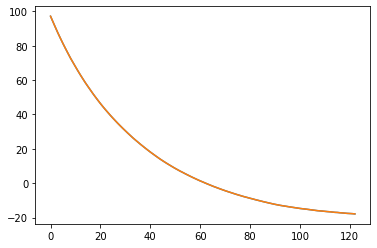

In [54]:
plt.plot(nat_temp - model['spectrum'])
plt.plot(model['recal_spec'] - model['spectrum'])

In [60]:
crazy_sampler = samplers.emcee(
    full_lk,
    output_dir=estpath/'emcee',
    output_prefix=full_lk.name,
    sampler_kwargs={
        'nwalkers': 24 * 10,
        'threads': 24
    }
)

In [78]:
crazy_mc_samples = crazy_sampler.sample(
    nsteps=3000,
)

Removed no burn in


In [62]:
crazy_emc_samples = crazy_sampler._sampler

In [75]:
np.savez(estpath / 'halfway_crazy.npz', chain = crazy_emc_samples.chain, lnprob=crazy_emc_samples.lnprobability, blobs=crazy_emc_samples.blobs)

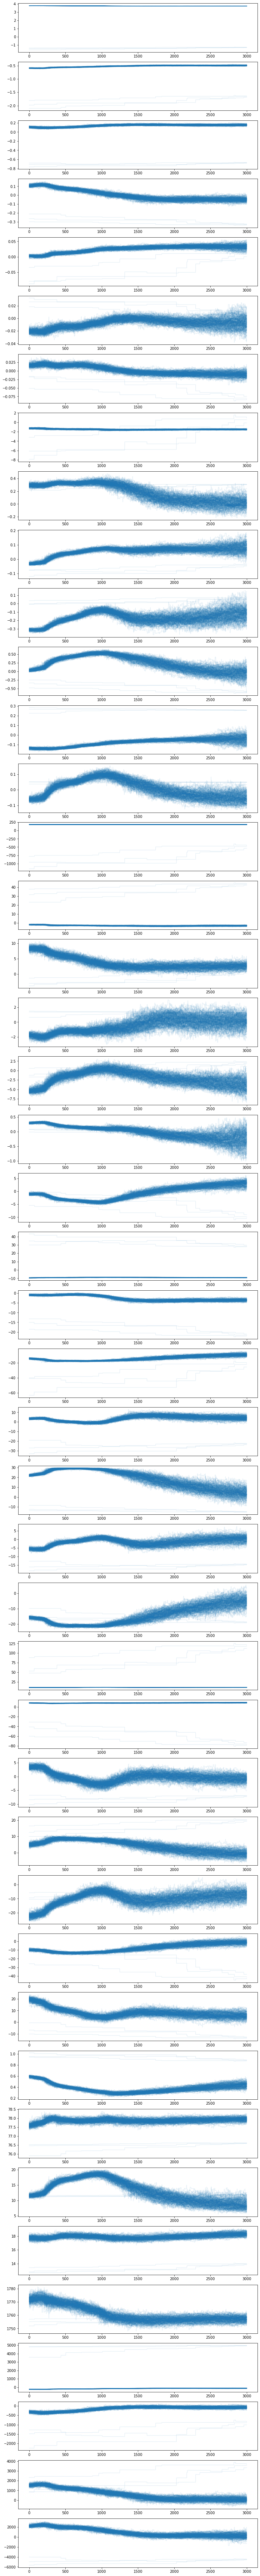

In [93]:
fig, ax = plt.subplots(crazy_emc_samples.chain.shape[-1], 1, figsize=(12, 3*(crazy_emc_samples.chain.shape[-1])))

for i, param in enumerate(crazy_emc_samples.chain.T):
    for walker in param.T:
        ax[i].plot(walker[3000:], color='C0', alpha=0.1)
        
#for walker in eor_emc_samples.lnprobability:
#    ax[-1].plot(walker, color='C0', alpha=0.1)

In [120]:
crazy_samples = crazy_emc_samples.get_chain(flat=True, discard=5500)

In [66]:
import corner

In [122]:
corner.corner?

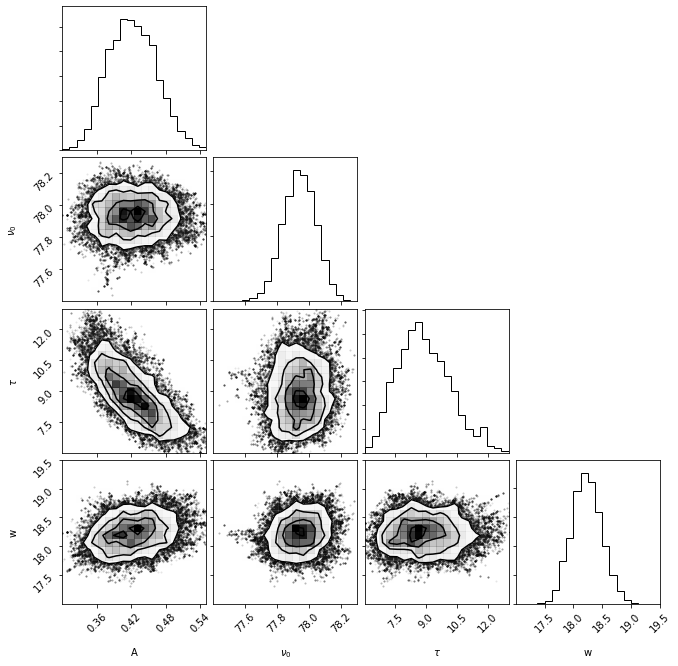

In [127]:
corner.corner(crazy_samples[:,-9:-5], range=[(0.3,0.55),(77.4, 78.3),(6,13),(17,19.5)], 
              labels=['A', r'$\nu_0$', r'$\tau$', 'w']);

In [68]:
corner.corner?

In [293]:
g.triangle_plot?

In [291]:
plots.get_single_plotter?

<Figure size 432x324 with 0 Axes>

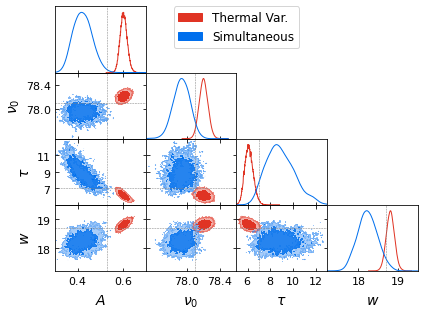

In [296]:
g = plots.get_single_plotter(width_inch=6, scaling=False)
g.triangle_plot(
    [simple_samp, crazy_samp], 
    filled=True, 
    param_limits={
        'A': (0.3, 0.7),
        'nu0': (77.5, 78.6),
        'tau': (5., 13),
        'w': (17.2,19.5)
    },
    markers={'A': 0.53, 'nu0': 78.1, 'w':18.7, 'tau':7}
)
plt.savefig("simultaneous_fit.pdf")

In [194]:
crazy_samp = MCSamples(samples=crazy_samples[:,-9:-5], names=['A', 'nu0', 'tau', 'w'], labels=['A', r'\nu_0', r'\tau', 'w'], label='Simultaneous')
simple_samp = MCSamples(samples=eor_emc_samples.get_chain(flat=True, discard=1500)[:, :4], names=['A', 'nu0', 'tau', 'w'], labels=['A', r'\nu_0', r'\tau', 'w'], label='Thermal Var.')

Removed no burn in
Removed no burn in


In [201]:
blobs = crazy_emc_samples.get_blobs(flat=True, discard=5500)

In [202]:
perc = np.percentile(blobs, [16, 50, 84], axis=0)

Text(0, 0.5, 'Absorption Amplitude [K]')

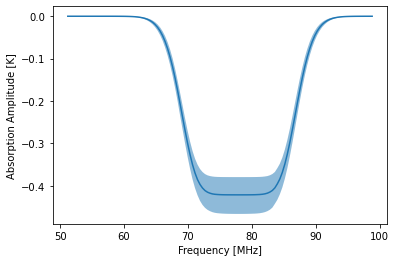

In [204]:
plt.fill_between(nat_freq, perc[0], perc[2], alpha=0.5)
plt.plot(nat_freq, perc[1])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Absorption Amplitude [K]")

## A Simple Test for Richard Hills

In [218]:
cterms=5
wterms=5
fmin = 50.
fmax = 100.

calobs_path = Path('/data5/edges/data/CalibrationObservations/Receiver01/Receiver01_25C_2015_09_02_040_to_200MHz')

In [219]:
!python {calpath/'create_config.py'} {calobs_path} -l {fmin} -h {fmax} -c {cterms} -w {wterms}

Wrote config to /data4/smurray/Projects/radio/EOR/Edges/bayesian-calibration/nature-paper/calibration/Receiver01_25C_2015_09_02_040_to_200MHz_l50.0MHz_h100.0MHz_c5_w5bounds/config.yml


In [239]:
cal_lk_5 = load_likelihood_from_yaml(calpath / f"{calobs_path.name}_l{fmin}MHz_h{fmax}MHz_c{cterms}_w{wterms}bounds/config.yml")

In [241]:
calobs5 = cal_lk_5['calibrator'].calobs

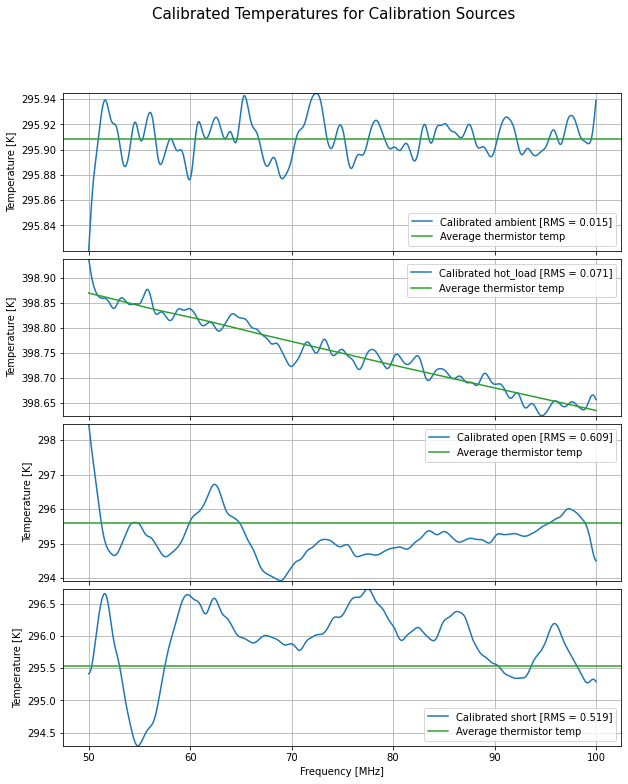

In [242]:
calobs5.plot_calibrated_temps();

In [256]:
params = Parameters()
for name, param in cal_lk_5.child_active_param_dct.items():
    params.add(name, value=param.fiducial, min=param.min, max=param.max)

In [258]:
cal_lstsq_res5 = Minimizer(calibration_objective, params, nan_policy='omit', fcn_kws={'lk':cal_lk_5}).minimize(method='lstsq')

/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/lmfit/minimizer.py:779: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
/home/smurray/miniconda3/envs/edges/lib/python3.7/site-packages/lmfit/minimizer.py:786: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.result.covar[jvar, jvar])))


In [228]:
cal_lstsq_res.success

True

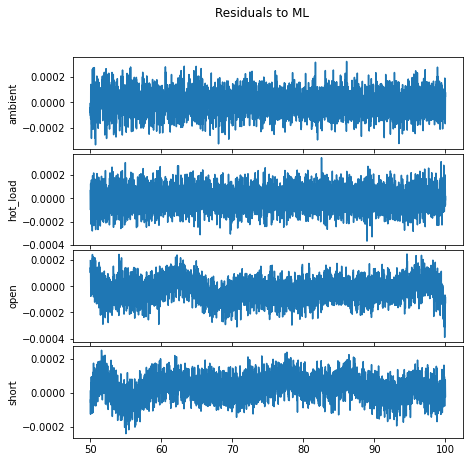

In [229]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(7,7), gridspec_kw={"hspace":0.05})

fid_model = cal_lk.reduce_model()
data_mask = fid_model['data_mask']
fid_model = fid_model['Qp']

ml_params = [p.value for p in cal_lstsq_res.params.values()]
ml_model = cal_lk.reduce_model(params=ml_params)['Qp']

fig.suptitle("Residuals to ML")
for i, (name, fid) in enumerate(fid_model.items()):
    ax[i].plot(cal_lk['calibrator'].freq, cal_lk.data[name][data_mask] - ml_model[name])
    #ax[i].plot(cal_lk['calibrator'].freq, fid - ml_model[name], lw=2)
    ax[i].set_ylabel(name)

In [236]:
def recalibrate(freq, temp, params, fid, K, like):
    scale, offset, tu, tc, ts = get_cal_curves(params, like)

    a, b = rcf.get_linear_coefficients_from_K(
        K, scale(freq), offset(freq), tu(freq), tc(freq), ts(freq), t_load=300,
    )

    decal = (temp - b)/a

    a, b = rcf.get_linear_coefficients_from_K(
        K, fid['c1'](freq), fid['c2'](freq), fid['tunc'](freq), fid['tcos'](freq), fid['tsin'](freq), t_load=300,
    )
    
    return decal*a + b

In [234]:
cal_lstsq_res.x

array([ 2.33916626e-04,  1.70413624e-04, -1.01894678e-05,  8.86188828e-04,
       -2.42091123e-03, -8.05677776e-04, -1.27221370e-04,  9.71084588e-04,
        1.46363217e-03, -1.46589456e-05, -1.44342304e-04, -2.67664007e-03,
        8.38826031e-04,  1.50898234e-04,  7.16554285e-04, -2.17492614e-04,
       -8.89236969e-04, -4.81224391e-04,  6.55932200e-04,  9.38616722e-05,
        6.69049647e-05,  1.87805627e-04, -3.36433687e-04,  9.71597115e-04,
        8.99293866e-04])

In [237]:
recal_temp = recalibrate(nat_freq_renorm, nat_temp, cal_lstsq_res.x, fid, K, cal_lk)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [238]:
fid

array([-0.04872757, -0.04875448, -0.0487815 , ..., -0.06256914,
       -0.06257139, -0.06257363])

In [ ]:
fid = get_fid(means, cal_lk)